# Type 1 diabetes risk classification
I have generated the dataset from the data processing and analysis notebook. The next step is to train models to predict Type 1 diabetes risk for individuals. I will try a variety of modesl to see which one has the best performance. The metrics we will use are AUC, f1, recall, precision, and specificity. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('simulated_data.csv')

In [3]:
print(df.shape)
df

(10000, 80)


,Unnamed: 0,rs10751776,rs574384,rs12742756,rs855330,rs1493696,rs570794153,rs12128789,rs1881146,rs12464462,...,rs35122968,rs3997848,rs241427,rs4148870,rs3128930,rs2085277,rs559047,rs61211515,prs,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.518000,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.160712,0
2,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2.131389,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.210983,1
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.222000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.953529,0
9996,9996,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0.957718,0
9997,9997,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1.555464,0
9998,9998,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.765029,0


In [4]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train.shape)

(8000, 79)
(2000, 79)
(8000,)
(8000,)


In [6]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    labels = ['Low', 'Medium', 'High']
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s Risk' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


# Logistic Regression

In [8]:
lr = linear_model.LogisticRegression(max_iter=700)

params = {'tol':[0.1, 0.001, 1e-5], 'C':[10, 1, 0.1]}

lr_opt = GridSearchCV(lr, params, cv=5, scoring='f1_micro')
lr_opt.fit(X_train, y_train)

print('The best parameters are:')
for key, val in lr_opt.best_params_.items():
    print(str(key) + ':', val)

The best parameters are:
C: 0.1
tol: 0.001


              precision    recall  f1-score   support

    Low Risk       0.93      0.93      0.93      1007
 Medium Risk       0.83      0.86      0.85       716
   High Risk       0.89      0.81      0.85       277

    accuracy                           0.89      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.89      0.89      0.89      2000

auc score is:  0.9739094196080936


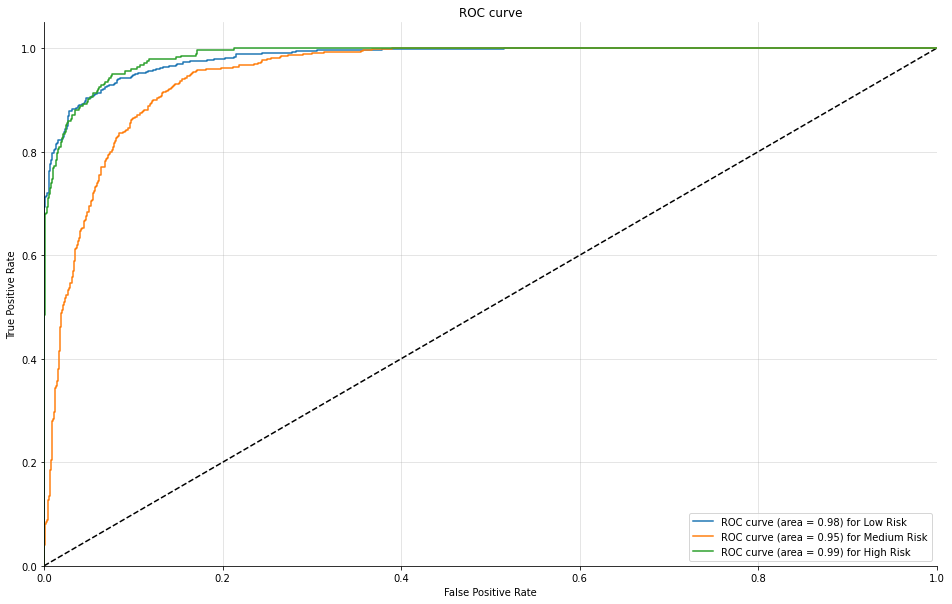

In [9]:
y_pred_lr = lr_opt.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, lr_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(lr_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

In [11]:
# from sklearn.externals import joblib
import joblib
  
# Save the model as a pickle in a file
joblib.dump(lr_opt, 'logreg-model.pkl')

['logreg-model.pkl']

In [12]:
# Load the model from the file
lg_from_joblib = joblib.load('logreg-model.pkl') 
  
# Use the loaded model to make predictions
lg_from_joblib.predict(X_test)

print(classification_report(y_test, y_pred_lr, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.93      0.93      0.93      1007
 Medium Risk       0.83      0.86      0.85       716
   High Risk       0.89      0.81      0.85       277

    accuracy                           0.89      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.89      0.89      0.89      2000



# Naive Bayes

In [75]:
nb = GaussianNB()

params = {'var_smoothing': np.logspace(0,-9, num=100)}

nb_opt = GridSearchCV(nb, params, cv=5, scoring='f1_micro')
nb_opt.fit(X_train, y_train)

print('The best parameters are:')
for key, val in nb_opt.best_params_.items():
    print(str(key) + ':', val)

The best parameters are:
var_smoothing: 0.1873817422860384


              precision    recall  f1-score   support

    Low Risk       0.89      0.95      0.92      1007
 Medium Risk       0.86      0.78      0.81       716
   High Risk       0.85      0.83      0.84       277

    accuracy                           0.87      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.87      0.87      0.87      2000

auc score is:  0.973560498640209


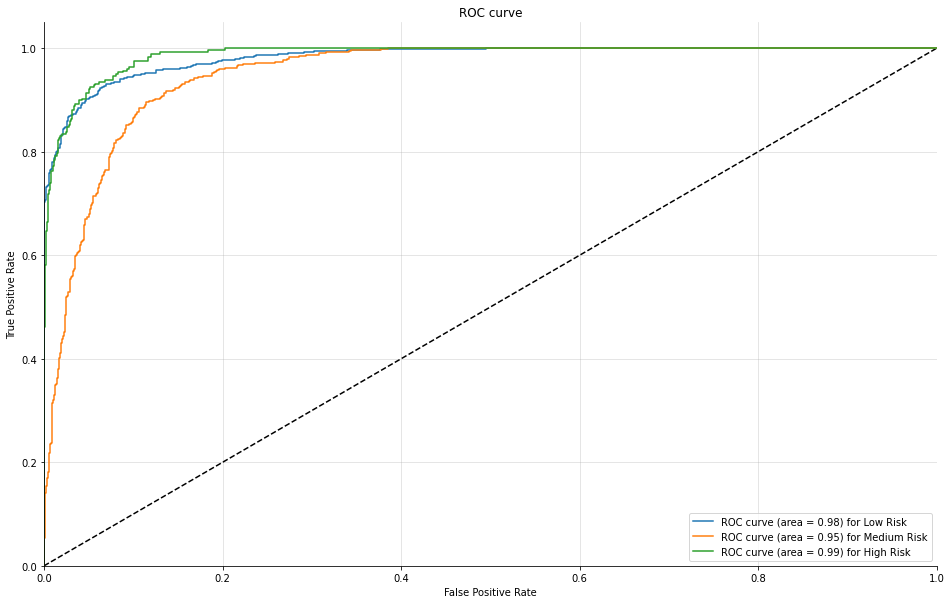

In [76]:
y_pred_nb = nb_opt.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, nb_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(nb_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

# Support Vector Machine

In [92]:
sv = svm.SVC(decision_function_shape='ovo', class_weight='balanced', probability=True)

params = {'C': [0.1, 1], 
              'gamma': [1, 0.1]}

svm_opt = GridSearchCV(sv, params, cv=5, scoring='f1_micro')
svm_opt.fit(X_train, y_train)

print('The best parameters are:')
for key, val in svm_opt.best_params_.items():
    print(str(key) + ':', val)

The best parameters are:
C: 1
gamma: 0.1


              precision    recall  f1-score   support

    Low Risk       0.94      0.91      0.93      1007
 Medium Risk       0.82      0.86      0.84       716
   High Risk       0.84      0.83      0.83       277

    accuracy                           0.88      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.88      0.88      0.88      2000

auc score is:  0.9704866277798745


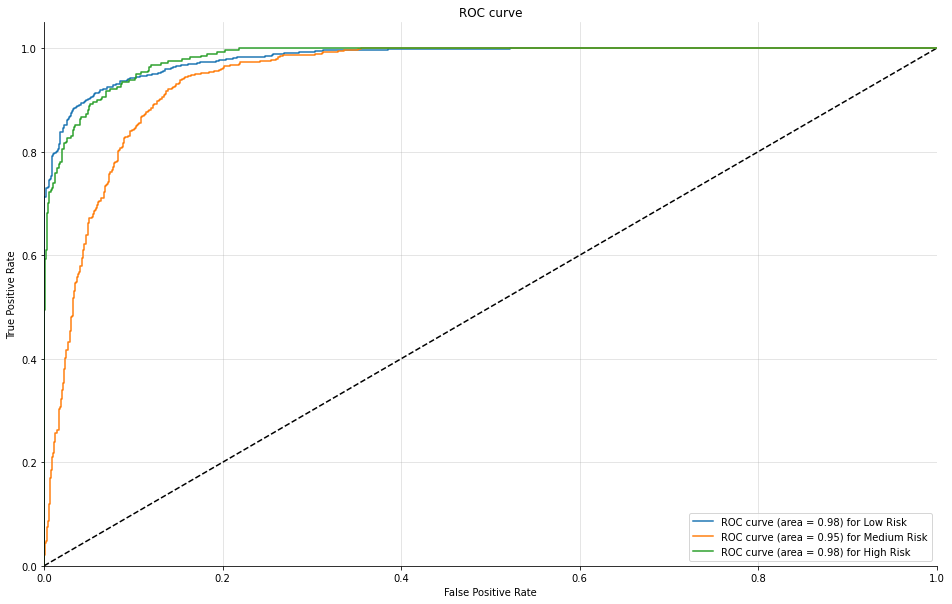

In [93]:
y_pred_svm = svm_opt.predict(X_test)
print(classification_report(y_test, y_pred_svm, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, svm_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(svm_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

# K-Nearest Neighbors

In [94]:
knn = KNeighborsClassifier()

params = {'n_neighbors': [3,5,11,19], 
              'weights': ['uniform', 'distance']}

knn_opt = GridSearchCV(knn, params, cv=5, scoring='f1_micro')
knn_opt.fit(X_train, y_train)

print('The best parameters are:')
for key, val in knn_opt.best_params_.items():
    print(str(key) + ':', val)

The best parameters are:
n_neighbors: 19
weights: uniform


              precision    recall  f1-score   support

    Low Risk       0.85      0.97      0.90      1007
 Medium Risk       0.90      0.50      0.64       716
   High Risk       0.60      0.96      0.74       277

    accuracy                           0.80      2000
   macro avg       0.78      0.81      0.76      2000
weighted avg       0.83      0.80      0.79      2000

auc score is:  0.9609147792125158


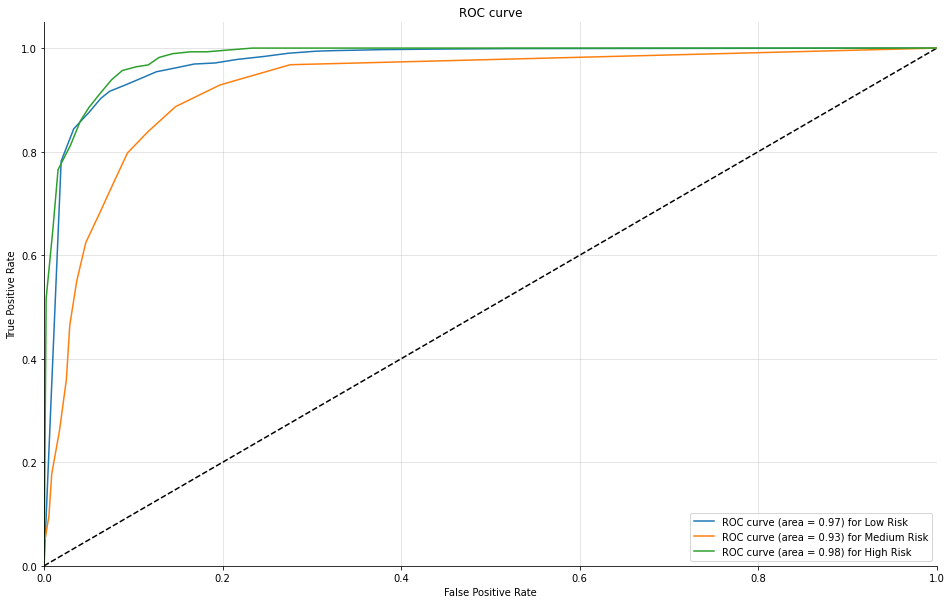

In [95]:
y_pred_knn = knn_opt.predict(X_test)
print(classification_report(y_test, y_pred_knn, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, knn_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(knn_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

# Decision Tree

In [96]:
dt = tree.DecisionTreeClassifier()

params = {'criterion':['gini','entropy']}

dt_opt = GridSearchCV(dt, params, cv=5, scoring='f1_micro')
dt_opt.fit(X_train, y_train)

print('The best parameters are:')
for key, val in dt_opt.best_params_.items():
    print(str(key) + ':', val)

The best parameters are:
criterion: entropy


              precision    recall  f1-score   support

    Low Risk       0.82      0.84      0.83      1007
 Medium Risk       0.65      0.62      0.63       716
   High Risk       0.67      0.69      0.68       277

    accuracy                           0.74      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.74      0.74      0.74      2000

auc score is:  0.7858020675858581


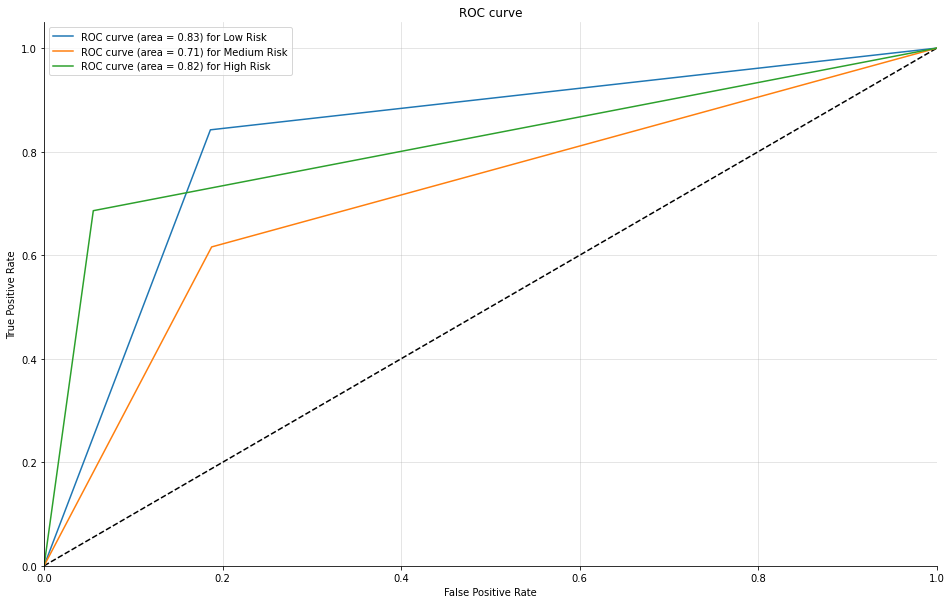

In [97]:
y_pred_dt = dt_opt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, dt_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(dt_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

# Multi-layer Perceptron

In [78]:
mlp = MLPClassifier()

params = {'hidden_layer_sizes': [(3,3),(5,5),(3,3,3)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.05],
    'learning_rate': ['adaptive']}

mlp_opt = GridSearchCV(mlp, params, cv=5, scoring='f1_macro')
mlp_opt.fit(X_train, y_train)

print('The best parameters are:')
for key, val in mlp_opt.best_params_.items():
    print(str(key) + ':', val)

The best parameters are:
activation: relu
alpha: 0.05
hidden_layer_sizes: (3, 3, 3)
learning_rate: adaptive
solver: adam


              precision    recall  f1-score   support

    Low Risk       0.92      0.92      0.92      1007
 Medium Risk       0.81      0.85      0.83       716
   High Risk       0.88      0.77      0.82       277

    accuracy                           0.88      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.88      0.88      0.88      2000

auc score is:  0.9717499723876234


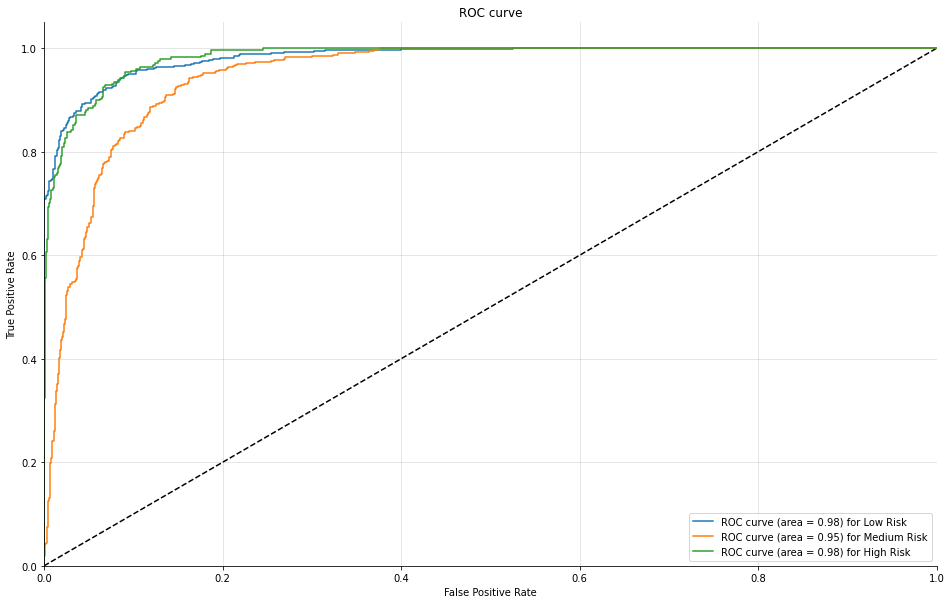

In [79]:
y_pred_mlp = mlp_opt.predict(X_test)
print(classification_report(y_test, y_pred_mlp, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, mlp_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(mlp_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

# Random Forest

In [80]:
rf = RandomForestClassifier()

params = { 'n_estimators': [900, 1000],
    'max_features': ['sqrt'],
    'max_depth' : [16,18,20],
    'criterion' :['gini'],
    'min_samples_split' : [2,4,5],
    'min_samples_leaf' : [1,2,4],
    'class_weight' :['balanced_subsample']}

rf_opt = GridSearchCV(rf, params, cv=5, scoring='f1_macro')
rf_opt.fit(X_train, y_train)

print('The best parameters are:')
for key, val in rf_opt.best_params_.items():
    print(str(key) + ':', val)

The best parameters are:
class_weight: balanced_subsample
criterion: gini
max_depth: 16
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 1000


              precision    recall  f1-score   support

    Low Risk       0.93      0.92      0.93      1007
 Medium Risk       0.81      0.88      0.84       716
   High Risk       0.91      0.76      0.83       277

    accuracy                           0.88      2000
   macro avg       0.88      0.85      0.87      2000
weighted avg       0.89      0.88      0.88      2000

auc score is:  0.9714299920246434


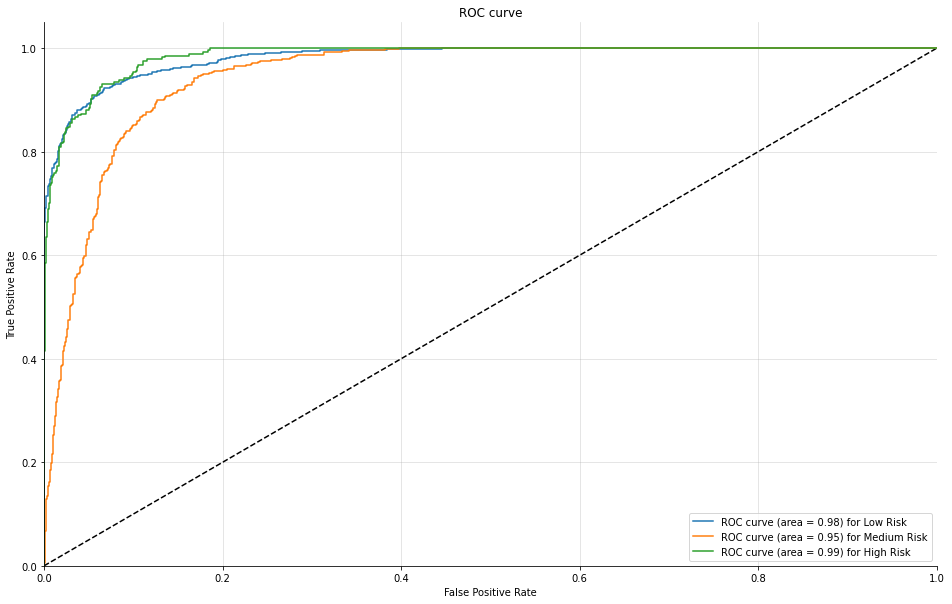

In [81]:
y_pred_rf = rf_opt.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, rf_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(rf_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

# XGBoost

In [13]:
# xgb_opt = XGBClassifier(verbosity=0, objective='multi:softmax', subsample=0.5, colsameple_bytree=1, learning_rate = 0.1, n_estimators=600, max_depth = 10)
xgb_opt = XGBClassifier(learning_rate=0.15, reg_alpha=0.1)
# params = {'learning_rate': [0.1],
#         'n_estimators': [600], 
#         'max_depth': [10]}

# xgb_opt = GridSearchCV(xgb, params, cv=5, scoring='f1_micro')
xgb_opt.fit(X_train, y_train)

# print('The best parameters are:')
# for key, val in xgb_opt.best_params_.items():
#     print(str(key) + ':', val)
    
    
# The best parameters are:
# colsample_bytree: 1
# gamma: 1
# learning_rate: 0.1
# max_depth: 10
# n_estimators: 600
# subsample: 0.5

[14:13:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

    Low Risk       0.89      0.89      0.89      1005
 Medium Risk       0.71      0.74      0.72       675
   High Risk       0.77      0.72      0.75       320

    accuracy                           0.81      2000
   macro avg       0.79      0.78      0.79      2000
weighted avg       0.81      0.81      0.81      2000

auc score is:  0.9398316724312736


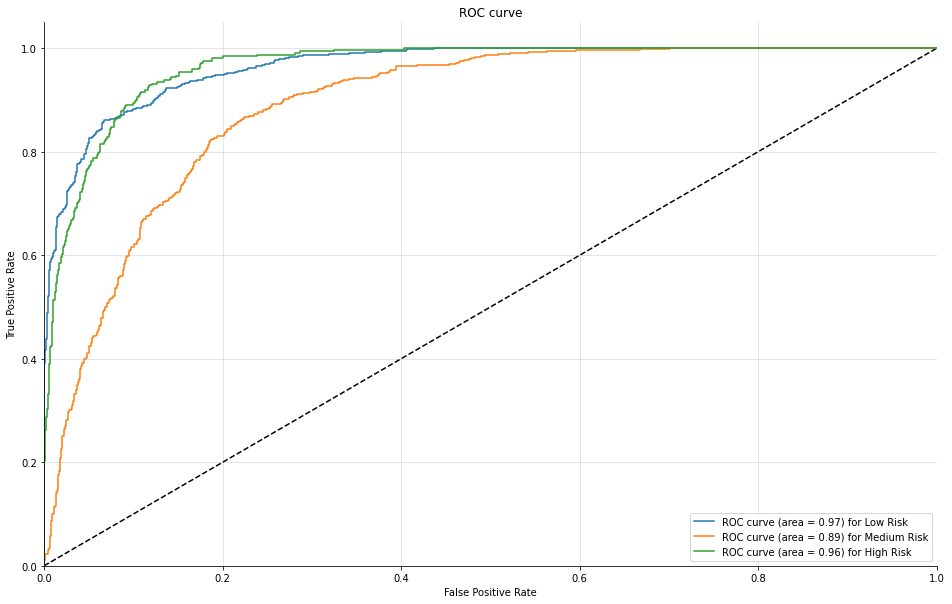

In [14]:
y_pred_xgb = xgb_opt.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, xgb_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(xgb_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

In [15]:
# from sklearn.externals import joblib
import joblib
  
# Save the model as a pickle in a file
joblib.dump(xgb_opt, 'diabetes-model.pkl')

['diabetes-model.pkl']

# Using Hyperopt for XGBoost

In [38]:
from hyperopt import hp
from hyperopt import Trials
from hyperopt import fmin, tpe
from hyperopt import STATUS_OK

In [64]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'learning_rate' : hp.quniform('learning_rate', 0.005,1,0.001),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 300,
        'seed': 0
    }

In [65]:
from sklearn.metrics import accuracy_score

def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    learning_rate = int(space['learning_rate']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="merror",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    score = f1_score(y_test, pred, average='micro')
    print ("SCORE:", score)
    return {'loss': -score, 'status': STATUS_OK }

In [66]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                               
0.5035                                               
SCORE:                                               
0.5035                                                             
SCORE:                                                             
0.5035                                                             
SCORE:                                                             
0.5035                                                             
SCORE:                                                             
0.5035                                                             
SCORE:                                                             
0.5035                                                             
SCORE:                                                             
0.5035                                                             
SCORE:                                                             
0.5035                

In [67]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9743626293033754, 'gamma': 6.41213019092588, 'learning_rate': 0.065, 'max_depth': 14.0, 'min_child_weight': 1.0}


In [68]:
xgb_new = XGBClassifier(verbosity=0,colsample_bytree=0.9, gamma=6, learning_rate= 0.065, max_depth=14, min_child_weight=1,n_estimators=300)
xgb_new.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=6, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.065, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [69]:
y_pred_new = xgb_new.predict(X_test)
print(classification_report(y_test, y_pred_new, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.92      0.93      0.93      1007
 Medium Risk       0.80      0.87      0.84       716
   High Risk       0.93      0.71      0.80       277

    accuracy                           0.88      2000
   macro avg       0.89      0.84      0.86      2000
weighted avg       0.88      0.88      0.88      2000

